In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
   print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()


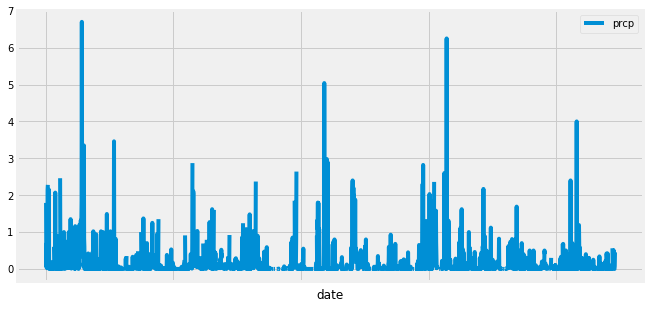

In [11]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date).all()
results_df = pd.DataFrame(results, columns=['date', 'prcp'])
results_df.set_index(results_df["date"], inplace=True)
results_df = results_df.sort_values("date")
results_df.plot(figsize=(10,5))


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_prcp_df = (results_df.describe().reset_index().
                   rename(columns={'index':'stat', 'prcp':'precipitation'}).copy())
#summary_prcp_df['precipitation'] = summary_prc_df['precipitation'].round(2)
summary_prcp_df

,stat,precipitation
0,count,2021.000000
1,mean,0.177279
2,std,0.461190
3,min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
conn = engine.connect()
hawaii_station = pd.read_sql("SELECT Station.station, Station.name, count(Measurement.station) as observations FROM Station join Measurement on Station.station = Measurement.station group by Station.station order by observations desc", conn)
hawaii_station.head()


,station,name,observations
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
conn = engine.connect()
temps_df = pd.read_sql("select min(tobs), max(tobs), avg(tobs) from Measurement where station = 'USC00519281'", conn)
temps_df

,min(tobs),max(tobs),avg(tobs)
0,54.0,85.0,71.663781


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117842278>]],
      dtype=object)

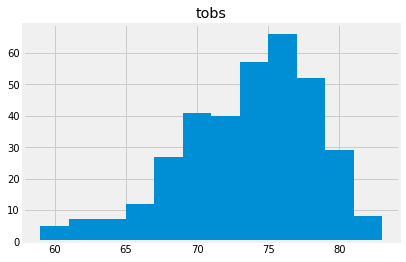

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histo = pd.read_sql("select date, tobs from Measurement where station = 'USC00519281' and date > '2016-08-23'", conn)
histo.head()
df = pd.DataFrame(histo, columns=['tobs'])
df.hist(bins=12)



In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): 2016-08-23
        end_date (string): 2017-08-23
        
    Returns:
        TMIN, TAVE, and TMAX
        """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_year_start = dt.date(2018,1,1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)
tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%y-%m-%d"), prev_year_end)[0]
print(tmin, tavg, tmax)
# print(calc_temps('2011-02-28', '2011-03-05'))

53.0 73.00698032318347 87.0


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


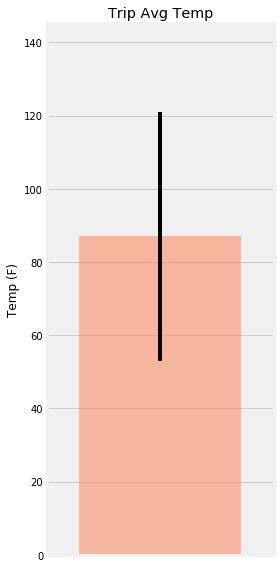

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize = plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr = yerr, alpha = 0.5, color= 'coral', align = "center")
ax.set(xticks = range(xpos), xticklabels = "a", title = "Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)

fig.tight_layout()
fig.show()


In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-01-01'
end_date = '2017-01-7'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).\
group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 7.529999999999999), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.57), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.89), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.84), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.66), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.41000000000000003), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.05)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
